Importando as bibliotecas necessárias

In [1]:
import logging
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec
from numpy import isin

SEED = 42
np.random.seed(SEED)

Criando um modelo Word2Vec com técnica skipgram

Carregando o spaCy para dentro da variável `nlp` que vai ser usada para o pré processamento

É possível desativar alguns módulos para melhorar o desempenho do treinamento mas neste caso vou tentar extrair o máximo de informação.

In [2]:
# nlp = spacy.load("pt_core_news_sm", disable=["paser", "ner", "tagger", "textcat"])
nlp = spacy.load("pt_core_news_sm")

Lendo as duas bases de dados e conferindo seus tamanhos sem nenhum tratamento.

In [3]:
news_caliman = pd.read_csv('datasets/kaggle_diogo_caliman_historico_materias.csv')
news_marlesson = pd.read_csv('datasets/kaggle_marlesson_noticias_folha_sp.csv')

print('sem drop de NaN: ', news_caliman.shape)
print('sem drop de NaN: ', news_marlesson.shape)

sem drop de NaN:  (10109, 6)
sem drop de NaN:  (167053, 6)


Tendo duas abordagens diferentes para testar resultados, na menor, removendo os dados que não possuem nada e na segunda, preenchendo eles com `stopwords`, depois verificando o tamanho que os dataframes ficaram.

In [4]:
news_caliman.dropna(inplace=True)
news_marlesson.fillna('e mas até', inplace=True)

print('com drop de NaN: ', news_caliman.shape)
print('com drop de NaN: ', news_marlesson.shape)

com drop de NaN:  (10099, 6)
com drop de NaN:  (167053, 6)


Verificando a quantidade de conteúdo por assunto no menor dataset.

In [5]:
news_caliman.assunto.value_counts()

esportes      6026
economia      1558
politica      1363
tecnologia     612
famosos        540
Name: assunto, dtype: int64

Fazendo uma análise de interesse é notável que o tema esporte não é muito útil para este caso, então removo-o.

In [6]:
news_caliman.drop(news_caliman[news_caliman['assunto'] == 'esportes'].index, inplace=True)

Revendo agora a quantidade de dados que nós temos e fica muito mais enxuto.

In [7]:
news_caliman.assunto.value_counts()

economia      1558
politica      1363
tecnologia     612
famosos        540
Name: assunto, dtype: int64

Criando uma função para limpar os dados junto ao nosso `nlp`, onde varremos cada `doc` e verificamos se não é uma `stopword` e se é `alphabetic`.

In [8]:
def clean_text(doc):
    result = ""

    for token in doc:
        is_valid = not token.is_stop and token.is_alpha

        if is_valid:
            result += f"{token} "

    return result.rstrip()

Inserindo os tamanhos de cada notícias para dentro do dataframe

In [9]:
news_caliman['tamanho_noticia'] = news_caliman.conteudo_noticia.str.len()

Conferindo a média e máxima dos tamanhos de textos

In [10]:
print(news_caliman['tamanho_noticia'].mean(), news_caliman['tamanho_noticia'].max());

3081.8219985268843 32851


# Separando as notícias por quantidade de caracteres.
large > 10000  
short < 3001  
medium >= 3001 e <= 6000  
medium_large >= 6001 e <= 10000

In [11]:
news_caliman.sort_values(by=['assunto', 'tamanho_noticia'], ascending=True, inplace=True);

In [12]:
def set_size(size):
    if(size <= 3000): return 'short'
    elif (size <= 6000): return 'medium'
    else: return 'large'

In [13]:
news_caliman['tamanho'] = news_caliman['tamanho_noticia'].map(set_size)

In [14]:
news_splited = np.array_split(news_caliman, 8)

# Inserindo a *tag* de tamanho para cada tipo de texto

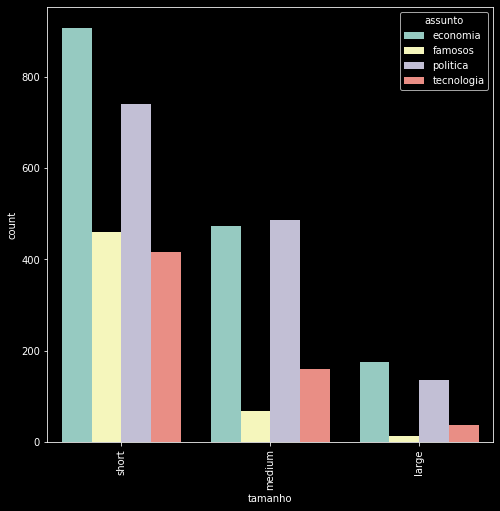

In [15]:
plt.figure(figsize=(8,8))
plt.xticks(rotation=90)
sns.countplot(x='tamanho', hue='assunto',data = news_caliman)
plt.show()


# Processando as notícias para limpar o texto

In [16]:
for news in news_splited:
    news_to_clean = (news.lower() for news in news["conteudo_noticia"])

In [17]:
news_cleaned = [clean_text(doc) for doc in nlp.pipe(news_to_clean,  batch_size = 10000, n_process = -1)]

In [18]:
news_to_list = pd.DataFrame({'news': news_cleaned})
news_to_list.drop_duplicates(inplace=True)

In [19]:
news_list = [news.split(' ') for news in news_to_list.news]

In [26]:
logging.basicConfig(format='%(asctime)s : - %(message)s', level=logging.INFO)

word_2_vec_skipgram_model = Word2Vec(sg = 1, window = 4, min_count = 5, vector_size = 300, alpha = 0.03, min_alpha=0.007)
word_2_vec_skipgram_model.build_vocab(news_list, progress_per=5000)
word_2_vec_skipgram_model.train(news_list, total_examples = word_2_vec_skipgram_model.corpus_count, epochs = 1000)
word_2_vec_skipgram_model.wv.save_word2vec_format('models/caliman/v2/sg_300.txt', binary=False)

2022-11-10 17:32:02,846 : - Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=300, alpha=0.03>', 'datetime': '2022-11-10T17:32:02.846874', 'gensim': '4.2.0', 'python': '3.7.13 (default, Oct 18 2022, 18:57:03) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.68.1-microsoft-standard-WSL2-x86_64-with-debian-bullseye-sid', 'event': 'created'}
2022-11-10 17:32:02,850 : - collecting all words and their counts
2022-11-10 17:32:02,851 : - PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-11-10 17:32:02,892 : - collected 16937 word types from a corpus of 123094 raw words and 508 sentences
2022-11-10 17:32:02,896 : - Creating a fresh vocabulary
2022-11-10 17:32:02,929 : - Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 4380 unique words (25.86% of original 16937, drops 12557)', 'datetime': '2022-11-10T17:32:02.929804', 'gensim': '4.2.0', 'python': '3.7.13 (default, Oct 18 2022, 18:57:03) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.68.1-microsoft-standar

In [28]:
logging.basicConfig(format='%(asctime)s : - %(message)s', level=logging.INFO)

word_2_vec_skipgram_model = Word2Vec(sg = 1, window = 50, min_count = 5, vector_size = 300, alpha = 0.03, min_alpha=0.007)
word_2_vec_skipgram_model.build_vocab(news_list, progress_per=5000)
word_2_vec_skipgram_model.train(news_list, total_examples = word_2_vec_skipgram_model.corpus_count, epochs = 1000)
word_2_vec_skipgram_model.wv.save_word2vec_format('models/caliman/v2/sg_300.txt', binary=False)

2022-11-10 17:38:02,743 : - Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=300, alpha=0.03>', 'datetime': '2022-11-10T17:38:02.743149', 'gensim': '4.2.0', 'python': '3.7.13 (default, Oct 18 2022, 18:57:03) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.68.1-microsoft-standard-WSL2-x86_64-with-debian-bullseye-sid', 'event': 'created'}
2022-11-10 17:38:02,745 : - collecting all words and their counts
2022-11-10 17:38:02,747 : - PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-11-10 17:38:02,764 : - collected 16937 word types from a corpus of 123094 raw words and 508 sentences
2022-11-10 17:38:02,765 : - Creating a fresh vocabulary
2022-11-10 17:38:02,781 : - Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 4380 unique words (25.86% of original 16937, drops 12557)', 'datetime': '2022-11-10T17:38:02.781224', 'gensim': '4.2.0', 'python': '3.7.13 (default, Oct 18 2022, 18:57:03) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.68.1-microsoft-standar

In [27]:
logging.basicConfig(format='%(asctime)s : - %(message)s', level=logging.INFO)

word_2_vec_skipgram_model = Word2Vec(sg = 1, window = 100, min_count = 5, vector_size = 300, alpha = 0.03, min_alpha=0.007)
word_2_vec_skipgram_model.build_vocab(news_list, progress_per=5000)
word_2_vec_skipgram_model.train(news_list, total_examples = word_2_vec_skipgram_model.corpus_count, epochs = 1000)
word_2_vec_skipgram_model.wv.save_word2vec_format('models/caliman/v3/sg_300.txt', binary=False)

2022-11-10 17:37:09,963 : - Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=300, alpha=0.03>', 'datetime': '2022-11-10T17:37:09.963646', 'gensim': '4.2.0', 'python': '3.7.13 (default, Oct 18 2022, 18:57:03) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.68.1-microsoft-standard-WSL2-x86_64-with-debian-bullseye-sid', 'event': 'created'}
2022-11-10 17:37:09,965 : - collecting all words and their counts
2022-11-10 17:37:09,966 : - PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-11-10 17:37:09,986 : - collected 16937 word types from a corpus of 123094 raw words and 508 sentences
2022-11-10 17:37:09,987 : - Creating a fresh vocabulary
2022-11-10 17:37:10,010 : - Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 4380 unique words (25.86% of original 16937, drops 12557)', 'datetime': '2022-11-10T17:37:10.010942', 'gensim': '4.2.0', 'python': '3.7.13 (default, Oct 18 2022, 18:57:03) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.68.1-microsoft-standar

KeyboardInterrupt: 

In [ ]:
logging.basicConfig(format='%(asctime)s : - %(message)s', level=logging.INFO)

word_2_vec_skipgram_model = Word2Vec(sg = 1, window = 4, min_count = 5, vector_size = 600, alpha = 0.03, min_alpha=0.007)
word_2_vec_skipgram_model.build_vocab(news_list, progress_per=5000)
word_2_vec_skipgram_model.train(news_list, total_examples = word_2_vec_skipgram_model.corpus_count, epochs = 1000)
word_2_vec_skipgram_model.wv.save_word2vec_format('models/caliman/v2/sg_600.txt', binary=False)

In [22]:
# logging.basicConfig(format='%(asctime)s : - %(message)s', level=logging.INFO)

# word_2_vec_skipgram_model = Word2Vec(sg = 1, window = 4, min_count = 5, vector_size = 1000, alpha = 0.03, min_alpha=0.007)
# word_2_vec_skipgram_model.build_vocab(news_list, progress_per=5000)
# word_2_vec_skipgram_model.train(news_list, total_examples = word_2_vec_skipgram_model.corpus_count, epochs = 1000)
# word_2_vec_skipgram_model.wv.save_word2vec_format('models/caliman/sg_1000.txt', binary=False)

In [23]:
# word_2_vec_skipgram_model_medium_vector = Word2Vec(sg = 1, window = 2, min_count = 5, vector_size = 300, alpha = 0.03, min_alpha=0.007)
# logging.basicConfig(format='%(asctime)s : - %(message)s', level=logging.INFO)
# word_2_vec_skipgram_model.build_vocab(news_list, progress_per=5000)
# word_2_vec_skipgram_model.train(news_list, total_examples = word_2_vec_skipgram_model.corpus_count, epochs = 10000)
# word_2_vec_skipgram_model.wv.save_word2vec_format('word_2_vec_sg_news_caliman_10k_epochs.txt', binary=False)

10k Épocas se mostrou tão ruim quanto muito poucas épocas

In [24]:
# logging.basicConfig(format='%(asctime)s : - %(message)s', level=logging.INFO)

# model = Word2Vec(sg = 1, window = 15, min_count = 5, vector_size = 300, alpha = 0.03, min_alpha=0.007, compute_loss=True)
# model.build_vocab(news_list, progress_per=5000)
# model.train(news_list, total_examples = model.corpus_count, epochs = 10000)
# model.wv.save_word2vec_format('models/tests/caliman/sg_300_epochs_10k.txt', binary=False)

In [25]:
model.wv.most_similar(positive=['negro'])

NameError: name 'model' is not defined

In [ ]:
model.wv.most_similar(positive=['negro'])

[('branco', 0.41985011100769043),
 ('kuwait', 0.39893001317977905),
 ('empregada', 0.3733461797237396),
 ('tor', 0.36995765566825867),
 ('domésticas', 0.3586956560611725),
 ('negros', 0.34776273369789124),
 ('empregadas', 0.3475266396999359),
 ('negras', 0.34635254740715027),
 ('nina', 0.31338343024253845),
 ('promover', 0.3113463222980499)]

In [ ]:
model.wv.most_similar(positive=['jovem'])

[('inglaterra', 0.2656373083591461),
 ('manhã', 0.25686386227607727),
 ('nina', 0.2547045350074768),
 ('jornais', 0.25246742367744446),
 ('álbum', 0.25210240483283997),
 ('mcafee', 0.24498580396175385),
 ('consumir', 0.24287791550159454),
 ('fax', 0.24162332713603973),
 ('campus', 0.23829549551010132),
 ('tempos', 0.23580192029476166)]